In [87]:
import nltk
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from nltk.tokenize import TreebankWordTokenizer,RegexpTokenizer
from sklearn.metrics import confusion_matrix, classification_report
from string import punctuation, digits
import pandas as pd
import altair as alt
eng_stopwords = set(stopwords.words('english'))

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load the data
Load the data from the top_10_channels_sampled.pickle file so we are working on the same dataset as the NLTK notebook

In [3]:
sampled_df = pd.read_pickle('top_10_channels_sampled.pickle')

In [4]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267925 entries, 0 to 267924
Data columns (total 5 columns):
index       267925 non-null int64
Id          267925 non-null object
answer      267925 non-null object
channel     267925 non-null object
question    267925 non-null object
dtypes: int64(1), object(4)
memory usage: 10.2+ MB


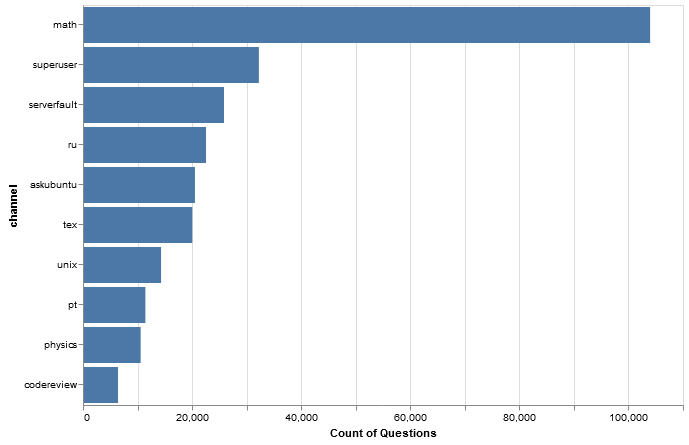

In [18]:
alt.Chart(pd.DataFrame(sampled_df['channel'].value_counts()).reset_index(),height=400,width=600).mark_bar().encode(y=alt.Y('index',title="channel",sort=alt.SortField(field='channel',order='ascending',op='values')),x=alt.X('channel',title="Count of Questions"))

# Define the function for tokenization

In [45]:
def tokenize(doc):
    doc = ' '.join(RegexpTokenizer(pattern=r'\b[^\d\W^_]+\b').tokenize(doc))
    doc = TreebankWordTokenizer().tokenize(doc)
    doc = [term for term in doc if term not in punctuation]
    doc = [term for term in doc if len(term) > 2]
    return doc

## Test the vectorizer outside of the pipeline
This will let us discover how many features it produces and what parameters are suitable. The specific features tested are the custom tokenizer, and the min_df settings.<br>
The min_df setting is specifically sensitive as it will not include features that don't appear in x% of the documents. With 268k documents this number should be really small, but not small enough where a word in one document is considered useful. The threshold of .05% was selected after many runs and provides almost eight thousand features.

In [55]:
vectorizer = CountVectorizer(binary=True,
                            encoding='utf-8',
                            stop_words=eng_stopwords,
                            lowercase=True,
                            #ngram_range=(2,2),
                            min_df=.0005,
                            #max_df=.20,
                            #norm='l2',
                            #use_idf=True,
                            strip_accents='unicode',
                            tokenizer=tokenize,
                            )
vectorized = vectorizer.fit_transform(sampled_df['question'])

In [56]:
len(vectorizer.get_feature_names())

7953

### Ensure the features are sane
We can examine the features returned by the vectorizer and confirm that these features are indeed real words, not nonsense programming and formatting, and we also ensure that the Russian text is intact. I had speculated that the Russian text would be eliminated because NLP tokenizers are focused on english text and that the RegExpTokenizer or TreeBankWordTokenizer functions might eliminate them. Thankfully, i was wrong.

In [76]:
vectorizer.get_feature_names()[-50:]

['формы',
 'фрагмент',
 'функции',
 'функцию',
 'функция',
 'хорошо',
 'хотел',
 'хотелось',
 'хотя',
 'хочет',
 'хочется',
 'хочу',
 'хранится',
 'хранить',
 'цвет',
 'цикл',
 'цикла',
 'цикле',
 'цифры',
 'части',
 'часть',
 'чего',
 'чем',
 'через',
 'чисел',
 'числа',
 'число',
 'что',
 'чтоб',
 'чтобы',
 'шаблон',
 'экран',
 'экрана',
 'элемент',
 'элемента',
 'элементов',
 'элементы',
 'эта',
 'эти',
 'этим',
 'этих',
 'это',
 'этого',
 'этои',
 'этом',
 'этому',
 'этот',
 'эту',
 'является',
 'язык']

In [78]:
rf_pipe = Pipeline([('vector',CountVectorizer(binary=True,
                                                      encoding='utf-8',
                                                      stop_words=eng_stopwords,
                                                      lowercase=True,
                                                      #ngram_range=(2,2),
                                                      min_df=.0005,
                                                      #max_df=.20,
                                                      #norm='l2',
                                                      #use_idf=True,
                                                      strip_accents='unicode',
                                                      tokenizer=tokenize,
                                                      )),
                     ('rf',RandomForestClassifier())
                    ])

In [79]:
scores = cross_val_score(rf_pipe,X=sampled_df['question'],y=sampled_df['channel'],cv=5)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change 

In [80]:
print('Sores for each fold:\n{}\n{}\nMean Score: {:.3f}'.format('-'*80,scores,scores.mean()))

Sores for each fold:
--------------------------------------------------------------------------------
[0.81141652 0.81152145 0.81075281 0.80983129 0.81132533]
Mean Score: 0.811


In [81]:
y_pred = cross_val_predict(rf_pipe,X=sampled_df['question'],y=sampled_df['channel'],cv=5)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change 

In [83]:
rf_cm = confusion_matrix(y_true=sampled_df['channel'],y_pred=y_pred)

Confusion matrix, without normalization
[[ 13083     42    588     25      3     25   1802   3747    108   1103]
 [    73   5303    396      3      8     88    196    203     65     87]
 [    70    123 102703    473      2     43     84    332    115     29]
 [    48      9   4322   5923      0     14     30    188     27      8]
 [     8     17     15      0  11354     22      9     10      0      3]
 [    36     97     51      5      5  22253     39     47      5     16]
 [  2224     99   1004     37      1     20  16977   4354     73   1062]
 [  3909    156   2078    118      4     26   5100  18871    380   1602]
 [   226     47   1533     28      2      6     90    706  17297     99]
 [  2859    122    686     17      1     15   2831   3839    157   3786]]


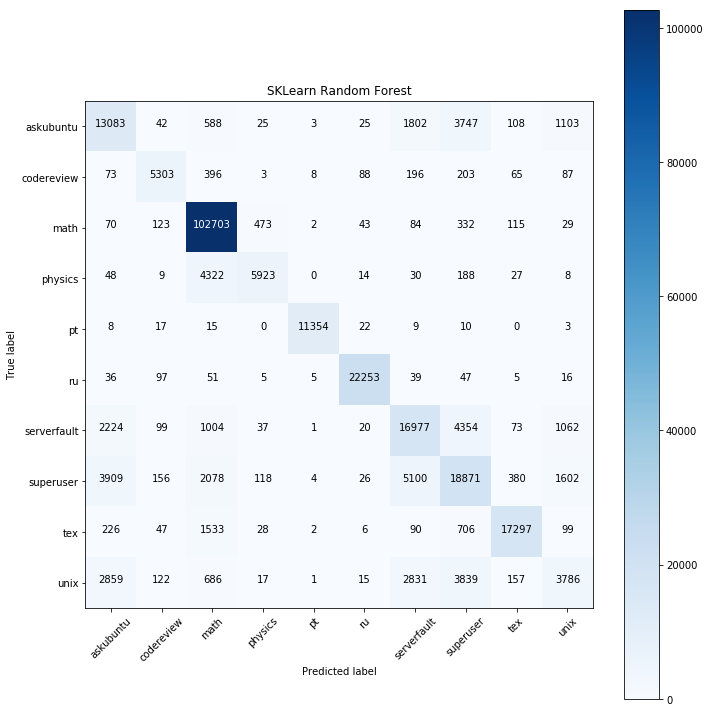

In [86]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(rf_cm,normalize=False,classes=['askubuntu','codereview','math','physics','pt','ru','serverfault','superuser','tex','unix'],title="SKLearn Random Forest")
plt.savefig('sklearn_rf_cm.jpg')

In [88]:
print(classification_report(y_true=sampled_df['channel'],y_pred=y_pred))

              precision    recall  f1-score   support

   askubuntu       0.58      0.64      0.61     20526
  codereview       0.88      0.83      0.85      6422
        math       0.91      0.99      0.95    103974
     physics       0.89      0.56      0.69     10569
          pt       1.00      0.99      1.00     11438
          ru       0.99      0.99      0.99     22554
 serverfault       0.63      0.66      0.64     25851
   superuser       0.58      0.59      0.58     32244
         tex       0.95      0.86      0.90     20034
        unix       0.49      0.26      0.34     14313

   micro avg       0.81      0.81      0.81    267925
   macro avg       0.79      0.74      0.75    267925
weighted avg       0.81      0.81      0.80    267925



## Fit the model outside of a CV to check feature importances

In [92]:
model = rf_pipe.fit(X=sampled_df['question'],y=sampled_df['channel'])

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [95]:
importances = model.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

### Print the top 50 important features

In [100]:
for x in indices[:50]:
    print(model.named_steps['vector'].get_feature_names()[x])

server
ubuntu
usepackage
mathbb
windows
есть
documentclass
frac
uma
running
как
file
command
можно
document
infty
let
для
latex
end
что
linux
сделать
prove
para
proof
все
return
нужно
como
energy
code
package
mas
files
user
installed
com
install
tex
que
если
rightarrow
directory
при
код
так
output
else
estou
